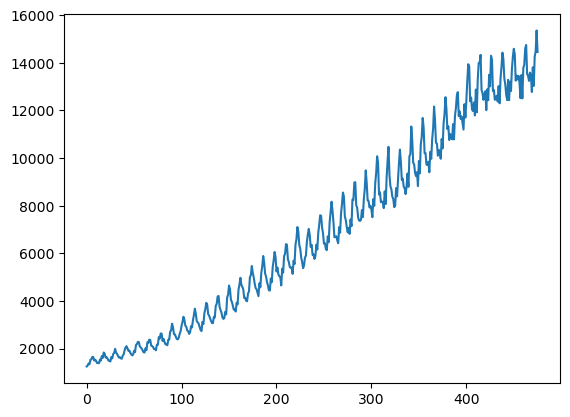

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

datos = pd.read_csv('AusElectDemand.csv', sep=";",decimal=",")
y = datos.iloc[:,1]

plt.plot(y)
plt.show()

In [2]:
import statsmodels as sm
import pmdarima
from pmdarima.arima import ndiffs, nsdiffs

# Ho: the process is not stationary. We need, at least, a unit root
# H1: the process is stationary. We have to check different models (lags)

adf_test = sm.tsa.stattools.adfuller(y,maxlag=10) 
# print("adf_test", adf_test) # first output "The test statistic", second output "p-value"
print("ADF test for the original series")
print("Statistic Value:" , adf_test[0])
print("p-value:" , adf_test[1])


# Tests
s = 12
d = ndiffs(y, alpha = 0.05, test='adf')  # regular differences?
D = nsdiffs(y, m = s, test='ocsb') # # seasonal differences?

print("Regular differences: ", d)
print('Seasonal differences:', D)

ADF test for the original series
Statistic Value: 2.390709545050104
p-value: 0.9990058702524236
Regular differences:  0
Seasonal differences: 0


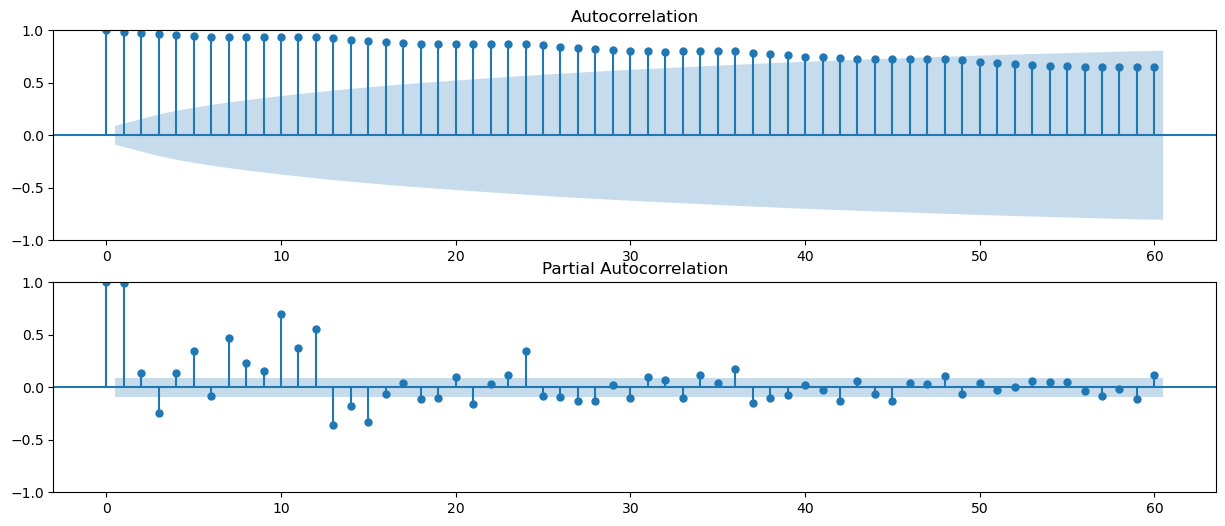

In [3]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

nlags = 60 # 8 years

# ValueError: Can only compute partial correlations for lags up to 50% of the sample size.

fig, ax = plt.subplots(2,1, figsize = (15,6))

plot_acf(y, lags = nlags, ax=ax[0])
plot_pacf(y, lags = nlags, method="ols", ax=ax[1])
plt.show()


                                     SARIMAX Results                                      
Dep. Variable:                              TOTAL   No. Observations:                  476
Model:             SARIMAX(8, 1, 0)x(4, 1, 0, 12)   Log Likelihood                1142.900
Date:                            Tue, 21 Mar 2023   AIC                          -2259.800
Time:                                    15:23:23   BIC                          -2206.010
Sample:                                         0   HQIC                         -2238.624
                                            - 476                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6602      0.050    -13.232      0.000      -0.758      -0.562
ar.L2         -0.4344      0.056   

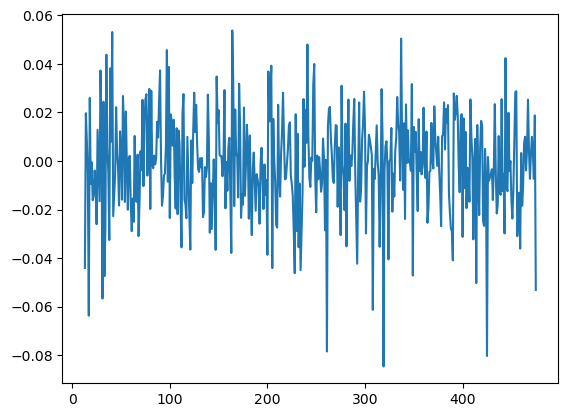

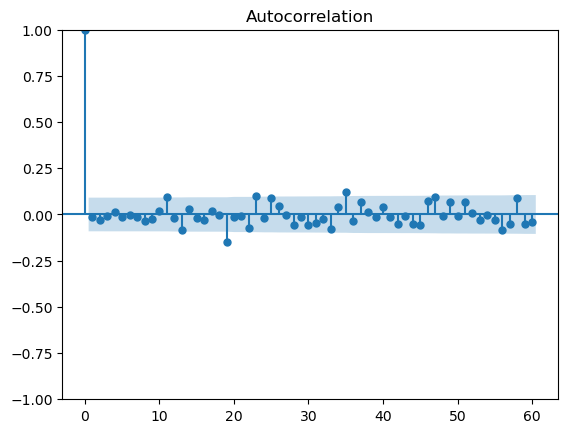

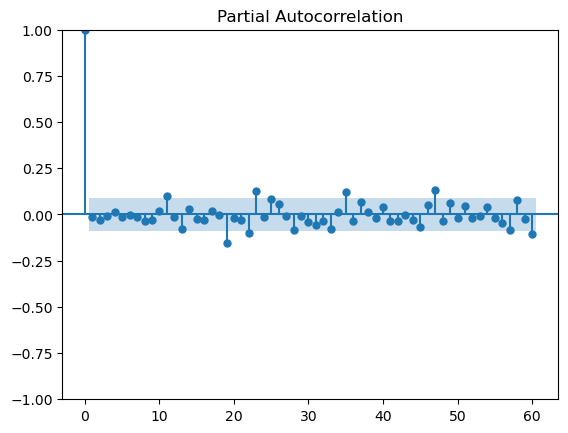

In [9]:
s = 12

#fit = SARIMAX(endog = np.log(y), order = (10,1,0), seasonal_order = (4,1,0,s)).fit()
#fit = SARIMAX(endog = y, order = (11,1,0), seasonal_order = (0,1,4,s)).fit()
fit = SARIMAX(endog = np.log(y), order = (8,1,0), seasonal_order = (4,1,0,s)).fit()

print(fit.summary())
residuos = fit.resid[13:]

nlags=60

plt.plot(residuos)
plt.show()
plot_acf(residuos, lags = nlags)
plt.show()
plot_pacf(residuos, method="ols",lags = nlags)
#plot_pacf(residuos,lags = nlags)
plt.show()

In [10]:
d = ndiffs(residuos, alpha = 0.05, test='adf')  # regular differences?
D = nsdiffs(residuos, m = s, test='ocsb') # # seasonal differences?

adf_test = sm.tsa.stattools.adfuller(residuos,maxlag=2) 
# print("adf_test", adf_test) # first output "The test statistic", second output "p-value"
print("ADF test for the original series")
print("Statistic Value:" , adf_test[0])
print("p-value:" , adf_test[1])

print("Regular differences: ", d)
print('Seasonal differences:', D)

ADF test for the original series
Statistic Value: -21.69133118569827
p-value: 0.0
Regular differences:  0
Seasonal differences: 0


Ljung-Box: Statistic value 51.50878736559059 p-value 0.045278520716980165
Shapido: Statistic value 0.98580402135849 p-value 0.00017208831559401006


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


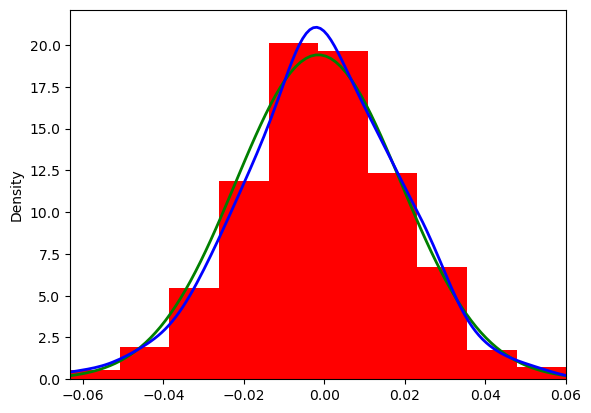

In [11]:
# Box test
import statsmodels.api as sm
box_test = sm.stats.acorr_ljungbox(residuos, lags=[36])

print("Ljung-Box: Statistic value", box_test.iloc[0,0], "p-value", box_test.iloc[0,1]) 

from scipy.stats import shapiro
import seaborn as sns
import scipy.stats as st

# Normalitresiduos test

saphiro = shapiro(residuos)
print("Shapido: Statistic value", saphiro[0],"p-value",saphiro[1]) # first output "The test statistic", second output "p-value"

mean = np.mean(residuos)
std = np.std(residuos)
mu = np.mean(residuos)
sigma = np.std(residuos)
x = np.linspace(mu -3*sigma, mu +3*sigma, 100)
pdf = st.norm.pdf(x, mu, sigma)
ax = plt.plot(x, pdf, lw = 2, color = "g")
ax = plt.hist(residuos,density=True, range = (mean - 3*std, mean + 3*std), color = "r")
ax = sns.distplot(residuos, hist = False, kde = True,
                 kde_kws = {'linewidth': 2}, color = "blue")
ax.set_xlim(mean - 3*std, mean + 3*std)

plt.show()

In [12]:
box_test2 = sm.stats.acorr_ljungbox(residuos**2, lags=[30])
print("Squared Residuals Box test:", box_test2.iloc[0,0],"p-value:", box_test2.iloc[0,1]) # 

Squared Residuals Box test: 31.445707311719342 p-value: 0.39373959024412797


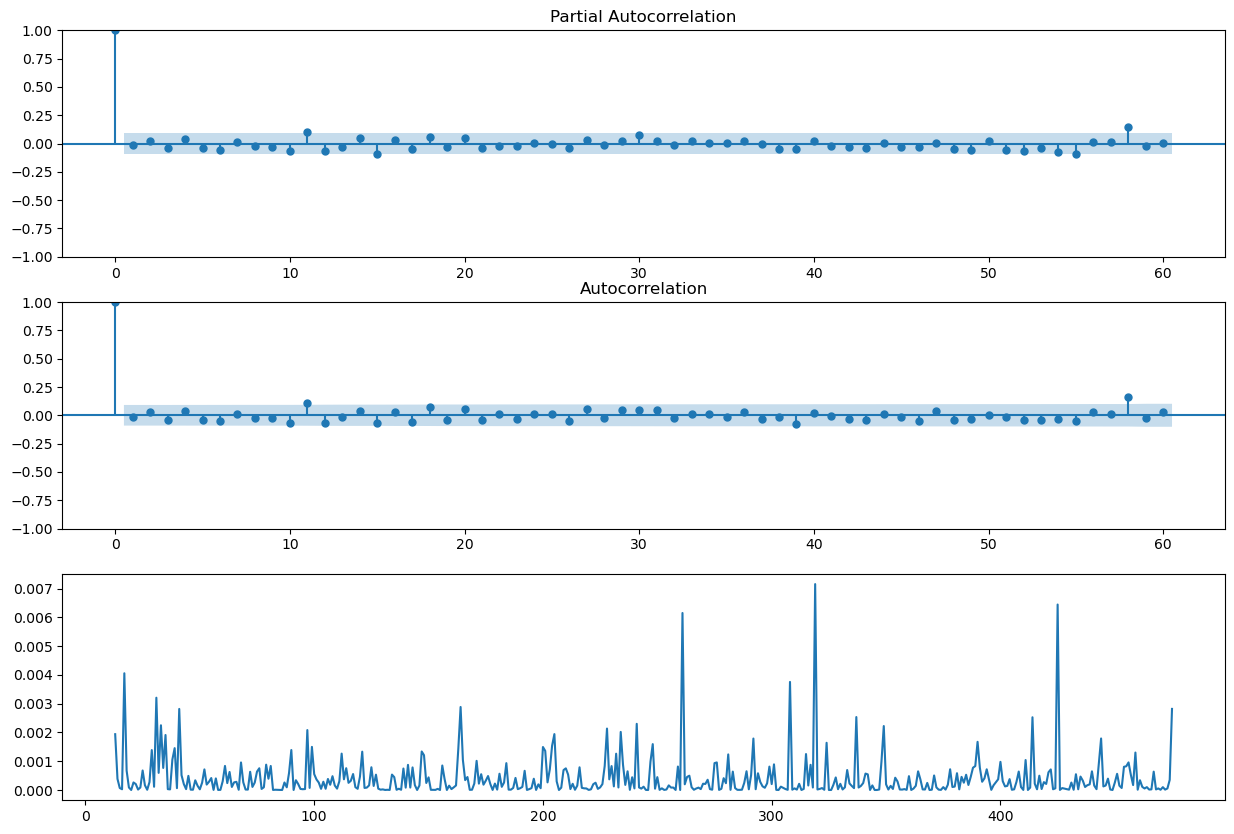

In [13]:
fig, ax = plt.subplots(3,1, figsize = (15,10))
plot_pacf(residuos**2, lags = nlags, method="ols", ax=ax[0])
plot_acf(residuos**2, lags = nlags, ax=ax[1])
ax[2] = plt.plot(residuos**2)
plt.show()

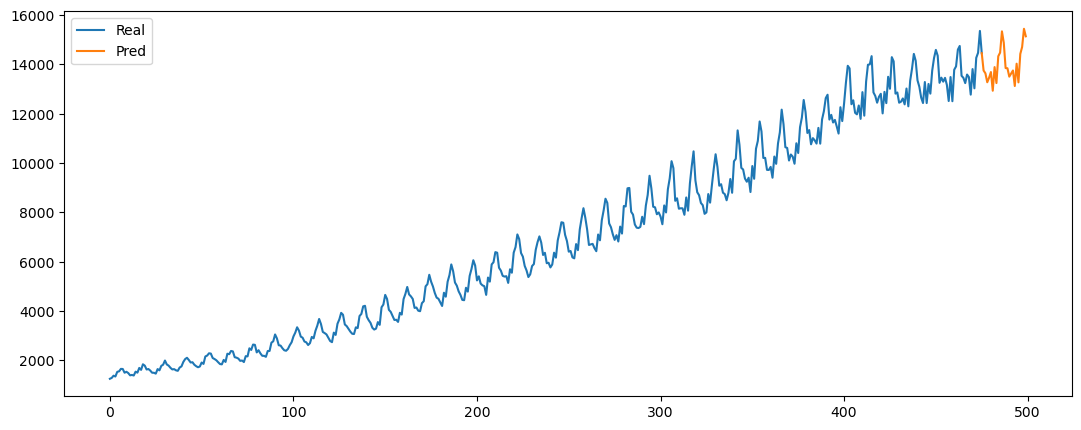

In [7]:
# Pintamos las siguientes 24 predicciones
y_pred = np.exp(fit.forecast(steps = 24))

# Ponemos el último índice real
y_pred.loc[len(y)-1] = y[len(y)-1]

# Reseteamos los índices, ordenamos por índice y volvemos a poner el índice como índice de la Serie.
y_pred = y_pred.reset_index().sort_values(by = 'index').set_index('index')

# Las predicciones dan 0, el modelo arriba que está con todos los parámetros en 0 salvo
# el 's' no sé si dará algún problema en Python y no lo haga como en R o me he equivocado en otro sitio
# print(y_pred)
plt.figure(figsize = (13,5))
plt.plot(y, label = 'Real')
plt.plot(y_pred, label = 'Pred')
plt.legend()
plt.show()

## Backtesting

In [114]:
long = len(y)
#Number of estimators we are going to use to calculate
n_estimation = long - 24
#Real values use to compare against predictions (24 values in this case)
real = y[(n_estimation):len(y)]
#Number of forecast we are going to do and how many horizons for each one
n_forecasting = long - n_estimation
#How many future horizons we want to predict in each iteration
horizontes = 4
#Variables where we are going to store the information calculated
predicc = np.zeros((horizontes,n_forecasting))
MSFE = np.zeros((horizontes, 1))
MAPE = np.zeros((horizontes, 1))
#Loop
for Periods_ahead in range(horizontes):
    for i in range(0,n_forecasting):
        #Previous real information we are going to use to fit the model
        aux_y = y[0:(n_estimation - Periods_ahead + i)]
        #Fit the model
        model = SARIMAX(endog = np.log(aux_y), order = (10,1,0), seasonal_order = (0,1,5,s))
        model_fit=model.fit()
        #Predict
        y_pred = np.array(model_fit.forecast(Periods_ahead + 1))
        #Save predictions
        predicc[Periods_ahead][i] = np.exp(y_pred[0])
    print(model_fit.summary())
    #Error calculations
    error = np.array(real) - predicc[Periods_ahead]
    MSFE[Periods_ahead] = np.mean(error**2)
    MAPE[Periods_ahead] = np.mean(np.abs(error/np.array(real))) * 100

#Printing the results
df_pred = pd.DataFrame({"V1":predicc[0], "V2":predicc[1]})
type(predicc)

print("MSFE",MSFE)
print("MAPE %",MAPE)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximu

                                             SARIMAX Results                                             
Dep. Variable:                                             TOTAL   No. Observations:                  475
Model:             SARIMAX(10, 1, 0)x(0, 1, [1, 2, 3, 4, 5], 12)   Log Likelihood                1143.915
Date:                                           Sat, 11 Mar 2023   AIC                          -2255.830
Time:                                                   19:01:43   BIC                          -2189.661
Sample:                                                        0   HQIC                         -2229.779
                                                           - 475                                         
Covariance Type:                                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximu

                                             SARIMAX Results                                             
Dep. Variable:                                             TOTAL   No. Observations:                  474
Model:             SARIMAX(10, 1, 0)x(0, 1, [1, 2, 3, 4, 5], 12)   Log Likelihood                1142.348
Date:                                           Sat, 11 Mar 2023   AIC                          -2252.696
Time:                                                   19:12:08   BIC                          -2186.561
Sample:                                                        0   HQIC                         -2226.656
                                                           - 474                                         
Covariance Type:                                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximu

                                             SARIMAX Results                                             
Dep. Variable:                                             TOTAL   No. Observations:                  473
Model:             SARIMAX(10, 1, 0)x(0, 1, [1, 2, 3, 4, 5], 12)   Log Likelihood                1139.419
Date:                                           Sat, 11 Mar 2023   AIC                          -2246.839
Time:                                                   19:23:09   BIC                          -2180.739
Sample:                                                        0   HQIC                         -2220.810
                                                           - 473                                         
Covariance Type:                                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximu

                                             SARIMAX Results                                             
Dep. Variable:                                             TOTAL   No. Observations:                  472
Model:             SARIMAX(10, 1, 0)x(0, 1, [1, 2, 3, 4, 5], 12)   Log Likelihood                1136.392
Date:                                           Sat, 11 Mar 2023   AIC                          -2240.784
Time:                                                   19:34:19   BIC                          -2174.719
Sample:                                                        0   HQIC                         -2214.767
                                                           - 472                                         
Covariance Type:                                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------